# Who are the high-frequency traders ?

First, import librairies.

In [24]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [25]:
# metrics proposed on the challenge website
def micro_average_f1_score(dataframe_y_true, dataframe_y_pred):
    """
    Args
        dataframe_y_true: Pandas Dataframe
            Dataframe containing the true values of y.
            This dataframe was obtained by reading a csv file with following instruction:
            dataframe_y_true = pd.read_csv(CSV_1_FILE_PATH, index_col=0, sep=',')

        dataframe_y_pred: Pandas Dataframe
            This dataframe was obtained by reading a csv file with following instruction:
            dataframe_y_pred = pd.read_csv(CSV_2_FILE_PATH, index_col=0, sep=',')

    Returns
        score: Float
            The metric evaluated with the two dataframes. This must not be NaN.
    """

    score = metrics.f1_score(dataframe_y_true["type"], dataframe_y_pred["type"], average = "micro")

    return score

## Data preprocessing

### Load the data

In this part we have a look at data and process them to be in the right form for the learning part.

In [26]:
x_train = pd.read_csv("data/AMF_train_X_XCZw8r3.csv", index_col=0, sep=',')
y_train = pd.read_csv("data/AMF_train_Y_omYQJZL.csv", index_col=0, sep=',')

In [27]:
nrows = len(x_train)
x_train

,Share,Day,Trader,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,...,min_dt_TV1_TV2,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade
Index,,,,,,,,,,,,,,,,,,,,,
1,Isin_8,Date_24,Trader_10,2.272727,8.333333,12.500000,0.0,5117.830300,0.000000,419.688500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2,Isin_87,Date_29,Trader_10,1.696629,25.166667,21.571429,0.0,1846.968401,0.000074,0.003374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
3,Isin_87,Date_23,Trader_10,1.482759,47.300000,118.250000,0.0,686.300630,0.000071,0.000599,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63
4,Isin_12,Date_11,Trader_10,1.705882,14.500000,29.000000,0.0,2174.335265,0.000000,6.152666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
5,Isin_87,Date_9,Trader_10,1.517730,26.750000,NaN,0.0,944.008551,0.000071,0.001364,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105778,Isin_84,Date_27,Trader_60,1.150000,23.000000,NaN,0.0,736.500080,0.000000,0.000188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
105779,Isin_102,Date_18,Trader_60,1.352941,23.000000,NaN,0.0,63.672695,0.000000,0.000963,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
105780,Isin_12,Date_13,Trader_60,1.146667,86.000000,NaN,0.0,708.440816,0.000000,0.000578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16


In [28]:
y_train

,type
Trader,
Trader_285,MIX
Trader_114,NON HFT
Trader_110,NON HFT
Trader_57,NON HFT
Trader_128,NON HFT
...,...
Trader_140,MIX
Trader_451,MIX
Trader_438,MIX


### Form the data

First, we merge the two tables to obtain label on each of the x_train row.

In [34]:
data_train = pd.merge(x_train, y_train, how = 'left', on=["Trader"])
data_train.head()

,Share,Day,Trader,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,...,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade,type
0,Isin_8,Date_24,Trader_10,2.272727,8.333333,12.500000,0.0,5117.830300,0.000000,419.688500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NON HFT
1,Isin_87,Date_29,Trader_10,1.696629,25.166667,21.571429,0.0,1846.968401,0.000074,0.003374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,NON HFT
2,Isin_87,Date_23,Trader_10,1.482759,47.300000,118.250000,0.0,686.300630,0.000071,0.000599,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63,NON HFT
3,Isin_12,Date_11,Trader_10,1.705882,14.500000,29.000000,0.0,2174.335265,0.000000,6.152666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NON HFT
4,Isin_87,Date_9,Trader_10,1.517730,26.750000,NaN,0.0,944.008551,0.000071,0.001364,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38,NON HFT


We drop the column trader, which is irrelevant for our task. We also cast columns share, day and type to int.

In [35]:
# replace the type 'HFT', 'MIX', and 'NON HFT' with labels 2, 1, 0

def map_to_int(x):
    if x=='HFT':
        return 2
    elif x=="MIX":
        return 1
    else:
        return 0

"""
for i in range(len(data_train)):
    if data_train['type'][i]=='HFT':
        data_train['type'][i]=2
    elif data_train['type'][i]=="MIX":
        data_train['type'][i]=1
    else:
        data_train['type'][i]=0
"""
data_train['type'] = data_train['type'].apply(lambda x : map_to_int(x))

label_train = data_train[['type', 'Trader']]

In [36]:
# drop the column trader
data_train.drop("Trader", axis=1, inplace=True)

# transform isin into int
data_train['Share'] = data_train['Share'].str[5:].astype(int)

# transform day into int
data_train['Day'] = data_train['Day'].str[5:].astype(int)

data_train.head()

,Share,Day,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,...,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade,type
0,8,24,2.272727,8.333333,12.500000,0.0,5117.830300,0.000000,419.688500,10.722543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0
1,87,29,1.696629,25.166667,21.571429,0.0,1846.968401,0.000074,0.003374,0.000204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,0
2,87,23,1.482759,47.300000,118.250000,0.0,686.300630,0.000071,0.000599,0.000129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63,0
3,12,11,1.705882,14.500000,29.000000,0.0,2174.335265,0.000000,6.152666,0.000945,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0
4,87,9,1.517730,26.750000,NaN,0.0,944.008551,0.000071,0.001364,0.000146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38,0


### Look at missing values

First, we have a look at NaN values in the dataframe.

In [37]:
data_train.dropna(inplace=False)

,Share,Day,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,...,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade,type
2136,45,19,3.828283,3.679612,758.000000,0.000000,8.159891,0.000100,1.128148,0.028501,...,122.778400,15.337,0.162,122.778400,15.337,0.162,122.778400,15.337,145,1
2142,22,6,3.554622,4.028571,282.000000,0.000000,25.144172,0.000108,6.878050,0.056661,...,128.091625,100.704,14.572,136.960333,136.500,14.572,128.091625,100.704,176,1
2145,58,19,4.366242,3.756164,342.750000,0.000000,23.728643,0.000117,0.547069,0.019218,...,87.520787,8.683,0.001,100.291563,51.380,0.001,100.291563,51.380,213,1
2151,96,10,5.530612,4.370968,90.333333,0.000000,65.091081,0.000006,2.066267,0.049307,...,112.042400,0.960,0.001,61.068900,0.871,0.001,108.254909,0.960,45,1
2155,31,19,4.852941,3.571429,103.125000,0.000000,27.298752,0.007578,8.965004,0.751817,...,160.484356,89.124,0.001,140.226689,74.835,0.001,138.856726,65.830,135,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105677,38,5,2.800000,9.333333,7.000000,0.000000,923.705447,0.000158,6.000009,0.000314,...,6546.000000,6546.000,6546.000,6546.000000,6546.000,6546.000,6546.000000,6546.000,8,0
105680,102,2,2.516484,13.470588,5.204545,0.000000,119.272342,0.000000,2.171315,0.000230,...,182.285714,11.000,1.000,182.285714,11.000,1.000,182.285714,11.000,78,0
105683,102,25,2.101695,9.538462,17.714286,0.000000,75.523207,0.000000,0.001557,0.000109,...,2.000000,2.000,2.000,2.000000,2.000,2.000,2.000000,2.000,15,0
105694,12,10,7.000000,7.000000,2.333333,0.009432,31.551883,0.009432,28.012953,19.563322,...,11.000000,11.000,11.000,11.000000,11.000,11.000,11.000000,11.000,2,0


Unfortunately, there are many rows with NaN values (the dataset is now only 43817 rows long).

Let's have a look at the columns containing NaNs.

In [38]:
# Number of rows with nan values for each column
columns_with_nan = []
for c in x_train.columns:
    if  nrows - len(x_train[c].dropna()) > 0:
        print(c, ' :', nrows - len(x_train[c].dropna()))
        columns_with_nan.append(c)
print(columns_with_nan)

OTR  : 1683
OMR  : 47612
min_dt_TV1  : 4235
mean_dt_TV1  : 4235
med_dt_TV1  : 4235
min_dt_TV1_TV2  : 25176
mean_dt_TV1_TV2  : 25176
med_dt_TV1_TV2  : 25176
min_dt_TV1_TV3  : 25255
mean_dt_TV1_TV3  : 25255
med_dt_TV1_TV3  : 25255
min_dt_TV1_TV4  : 25148
mean_dt_TV1_TV4  : 25148
med_dt_TV1_TV4  : 25148
['OTR', 'OMR', 'min_dt_TV1', 'mean_dt_TV1', 'med_dt_TV1', 'min_dt_TV1_TV2', 'mean_dt_TV1_TV2', 'med_dt_TV1_TV2', 'min_dt_TV1_TV3', 'mean_dt_TV1_TV3', 'med_dt_TV1_TV3', 'min_dt_TV1_TV4', 'mean_dt_TV1_TV4', 'med_dt_TV1_TV4']


For each of the above columns, we are going to look if their is a correlation between the presence of NaN values and the label of the row.

In [39]:
# dataframe with only columns containing NaN values
l = columns_with_nan+['type']
df_nan = data_train[l]
df_nan.head()

,OTR,OMR,min_dt_TV1,mean_dt_TV1,med_dt_TV1,min_dt_TV1_TV2,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,type
0,2.272727,12.500000,351.702399,9639.216031,1585.079495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1.696629,21.571429,0.000066,493.559196,0.000901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1.482759,118.250000,0.000018,163.954785,0.000770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1.705882,29.000000,0.000148,1232.562133,0.004301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1.517730,NaN,0.000025,248.073927,0.001364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [40]:
# Create categotical values : 0 means the value is NaN and label 1 means the value is defined
for c in columns_with_nan:
    df_nan[c] = np.where((df_nan[c].isnull()), 0, 1)
df_nan.head()

<ipython-input-40-b475165f4924>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nan[c] = np.where((df_nan[c].isnull()), 0, 1)


,OTR,OMR,min_dt_TV1,mean_dt_TV1,med_dt_TV1,min_dt_TV1_TV2,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,type
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
4,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0


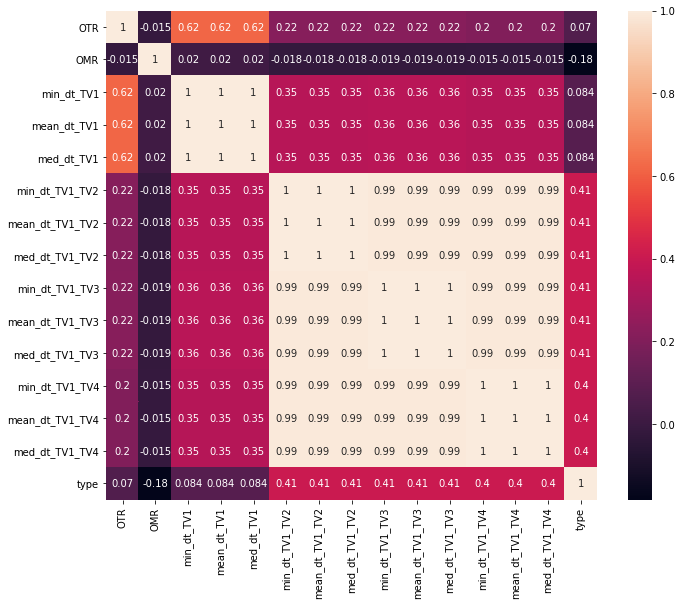

In [41]:
# plot the correlation matrix of the dataframe described above
corrMatrix = df_nan.corr()

f, ax = plt.subplots(figsize=(11, 9))

sn.heatmap(corrMatrix, annot=True)
plt.show()

In this part, we saw that there were numerous NaN values in the dataframe. If we remove all the rows containing NaN values, the dataframe is greatly reduced.
On the other hand, the presence of NaN value seams to be quite correlated with the type of the transaction. We obtain quite large correlation coefficient.

We will therefore have to find a way to exploit the data taking into account the NaN values.

### Look at the whole dataset

We start displayig some basic statistics on the data. This time, we consider defined values.

In [42]:
# Dataset obtained by removing rows with NaN values
data_na_droped = data_train.dropna(inplace=False)
data_na_droped.head()

,Share,Day,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,...,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade,type
2136,45,19,3.828283,3.679612,758.000000,0.0,8.159891,0.000100,1.128148,0.028501,...,122.778400,15.337,0.162,122.778400,15.337,0.162,122.778400,15.337,145,1
2142,22,6,3.554622,4.028571,282.000000,0.0,25.144172,0.000108,6.878050,0.056661,...,128.091625,100.704,14.572,136.960333,136.500,14.572,128.091625,100.704,176,1
2145,58,19,4.366242,3.756164,342.750000,0.0,23.728643,0.000117,0.547069,0.019218,...,87.520787,8.683,0.001,100.291563,51.380,0.001,100.291563,51.380,213,1
2151,96,10,5.530612,4.370968,90.333333,0.0,65.091081,0.000006,2.066267,0.049307,...,112.042400,0.960,0.001,61.068900,0.871,0.001,108.254909,0.960,45,1
2155,31,19,4.852941,3.571429,103.125000,0.0,27.298752,0.007578,8.965004,0.751817,...,160.484356,89.124,0.001,140.226689,74.835,0.001,138.856726,65.830,135,1


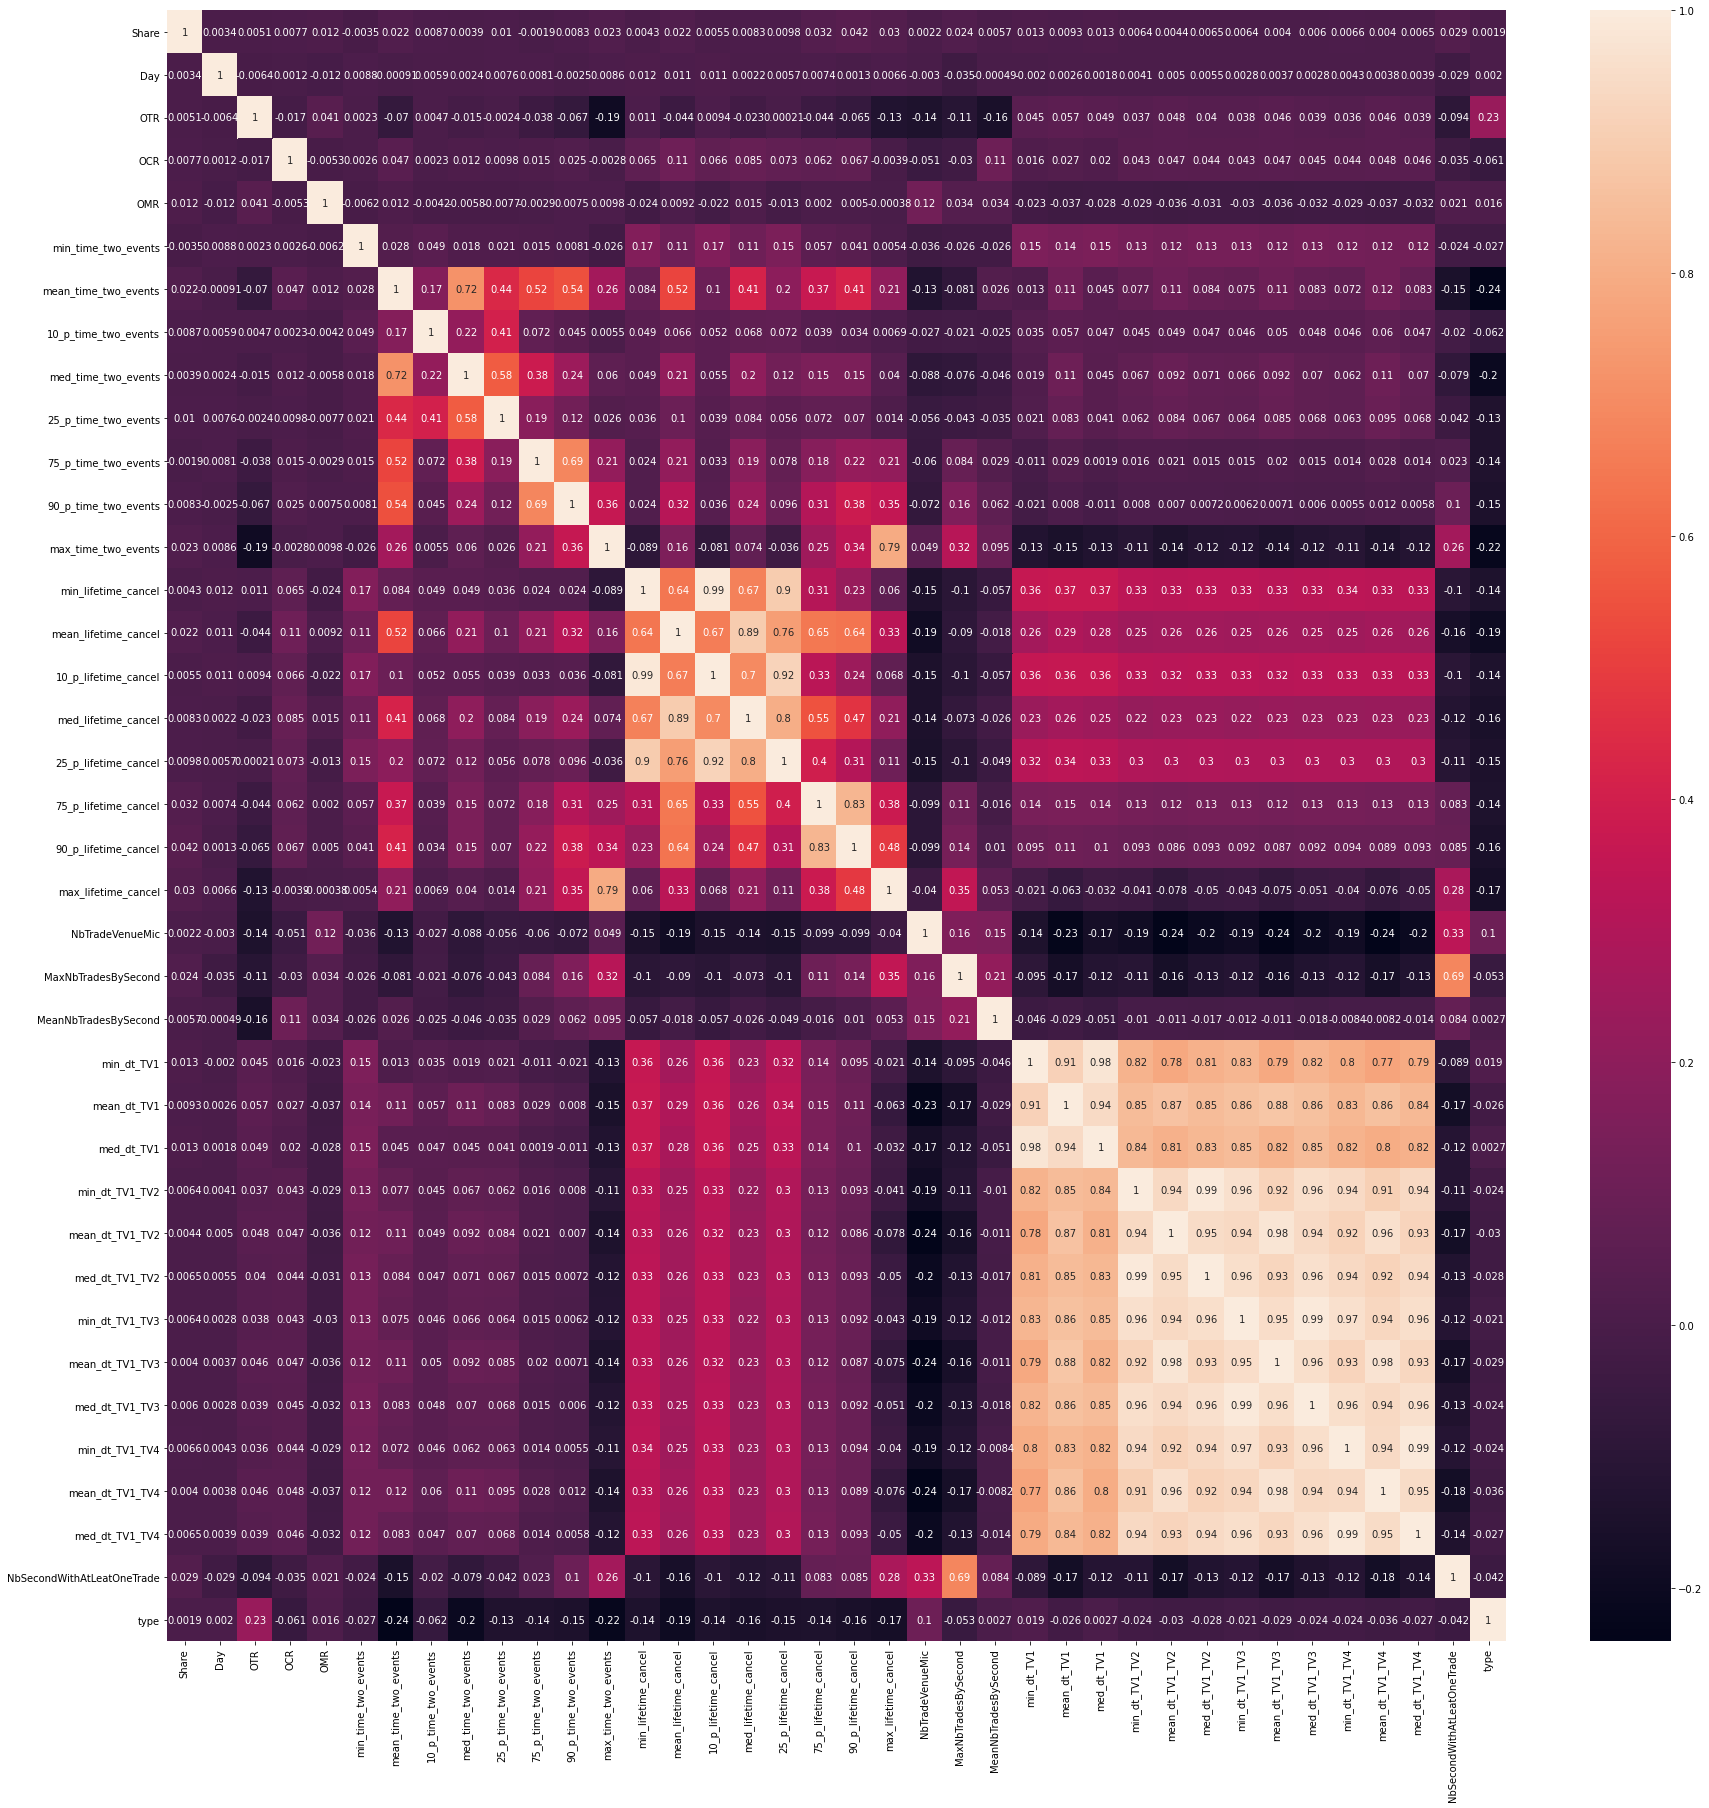

In [43]:
# plot the correlation matrix of the dataframe
corrMatrix = data_na_droped.corr()

f, ax = plt.subplots(figsize=(30, 30))

sn.heatmap(corrMatrix, annot=True)
plt.show()

We obtain quite low correlations. However, we droped many rows so this result can be biased. We now display the correlation matrix for the whole columns containing only defined values.

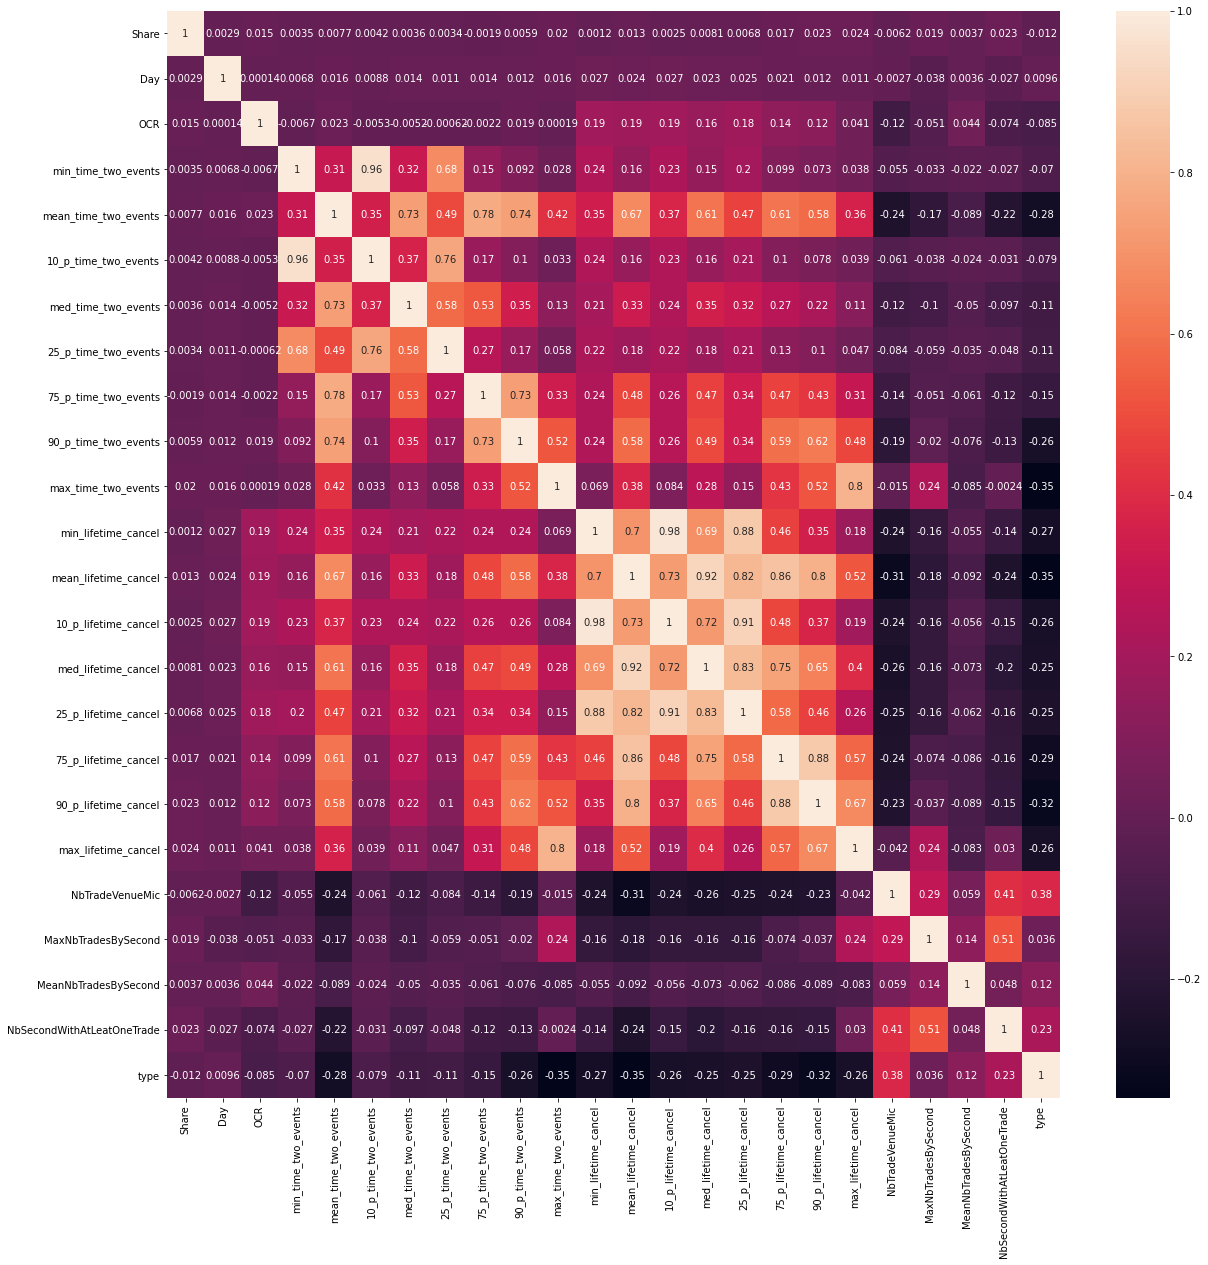

In [44]:
# plot the correlation matrix of the dataframe
data_whole_defined  = data_train.drop(columns=columns_with_nan, inplace=False)
corrMatrix = data_whole_defined.corr()

f, ax = plt.subplots(figsize=(20, 20))

sn.heatmap(corrMatrix, annot=True)
plt.show()

We decided to drop the columns Day and MeanNbTradesBySecond which doesn't seems to be very relevant to predict the type of a transaction.

In [45]:
data_train.drop(columns=["Day", "MeanNbTradesBySecond"], inplace=True)
data_train.head()

,Share,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,75_p_time_two_events,...,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade,type
0,8,2.272727,8.333333,12.500000,0.0,5117.830300,0.000000,419.688500,10.722543,984.320560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0
1,87,1.696629,25.166667,21.571429,0.0,1846.968401,0.000074,0.003374,0.000204,8.768699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,0
2,87,1.482759,47.300000,118.250000,0.0,686.300630,0.000071,0.000599,0.000129,5.725427,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63,0
3,12,1.705882,14.500000,29.000000,0.0,2174.335265,0.000000,6.152666,0.000945,62.444176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0
4,87,1.517730,26.750000,NaN,0.0,944.008551,0.000071,0.001364,0.000146,2.225420,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38,0


## Learning algorithms

We will now try different methods to classify traders.

As we are trying to predict labels, we are doing supervised learning. We will therefore use the supervised learning methods seen during the course, ensemble methods and neural networks.

To overcome the problem of missing values, we first tried to replace the missing values with the average value of the corresponding column. It is necessary to do so in order to avoid losing too much information by simply removing the missing values. 

In [46]:
# dataframe with means replacing missing values
df_nan_replaced = data_train.fillna(value=data_train.mean())
df_nan_replaced.head()

,Share,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,75_p_time_two_events,...,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade,type
0,8,2.272727,8.333333,12.500000,0.0,5117.830300,0.000000,419.688500,10.722543,984.320560,...,598.63774,389.411017,310.498829,605.733603,401.594794,309.912605,615.154194,402.749527,4,0
1,87,1.696629,25.166667,21.571429,0.0,1846.968401,0.000074,0.003374,0.000204,8.768699,...,598.63774,389.411017,310.498829,605.733603,401.594794,309.912605,615.154194,402.749527,15,0
2,87,1.482759,47.300000,118.250000,0.0,686.300630,0.000071,0.000599,0.000129,5.725427,...,598.63774,389.411017,310.498829,605.733603,401.594794,309.912605,615.154194,402.749527,63,0
3,12,1.705882,14.500000,29.000000,0.0,2174.335265,0.000000,6.152666,0.000945,62.444176,...,598.63774,389.411017,310.498829,605.733603,401.594794,309.912605,615.154194,402.749527,4,0
4,87,1.517730,26.750000,164.469153,0.0,944.008551,0.000071,0.001364,0.000146,2.225420,...,598.63774,389.411017,310.498829,605.733603,401.594794,309.912605,615.154194,402.749527,38,0


For classification, we will need binarized labels.

In [50]:
df_nan_replaced["HFT"] = np.where(df_nan_replaced["type"]==2, 1, 0)
df_nan_replaced["MIX"] = np.where(df_nan_replaced["type"]==1, 1, 0)
df_nan_replaced["NON_HFT"] = np.where(df_nan_replaced["type"]==0, 1, 0)

df_nan_replaced.head()

,Share,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,75_p_time_two_events,...,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade,type,HFT,MIX,NON_HFT
0,8,2.272727,8.333333,12.500000,0.0,5117.830300,0.000000,419.688500,10.722543,984.320560,...,605.733603,401.594794,309.912605,615.154194,402.749527,4,0,0,0,1
1,87,1.696629,25.166667,21.571429,0.0,1846.968401,0.000074,0.003374,0.000204,8.768699,...,605.733603,401.594794,309.912605,615.154194,402.749527,15,0,0,0,1
2,87,1.482759,47.300000,118.250000,0.0,686.300630,0.000071,0.000599,0.000129,5.725427,...,605.733603,401.594794,309.912605,615.154194,402.749527,63,0,0,0,1
3,12,1.705882,14.500000,29.000000,0.0,2174.335265,0.000000,6.152666,0.000945,62.444176,...,605.733603,401.594794,309.912605,615.154194,402.749527,4,0,0,0,1
4,87,1.517730,26.750000,164.469153,0.0,944.008551,0.000071,0.001364,0.000146,2.225420,...,605.733603,401.594794,309.912605,615.154194,402.749527,38,0,0,0,1


In [51]:
df_nan_replaced

,Share,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,75_p_time_two_events,...,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade,type,HFT,MIX,NON_HFT
0,8,2.272727,8.333333,12.500000,0.0,5117.830300,0.000000,419.688500,10.722543,984.320560,...,605.733603,401.594794,309.912605,615.154194,402.749527,4,0,0,0,1
1,87,1.696629,25.166667,21.571429,0.0,1846.968401,0.000074,0.003374,0.000204,8.768699,...,605.733603,401.594794,309.912605,615.154194,402.749527,15,0,0,0,1
2,87,1.482759,47.300000,118.250000,0.0,686.300630,0.000071,0.000599,0.000129,5.725427,...,605.733603,401.594794,309.912605,615.154194,402.749527,63,0,0,0,1
3,12,1.705882,14.500000,29.000000,0.0,2174.335265,0.000000,6.152666,0.000945,62.444176,...,605.733603,401.594794,309.912605,615.154194,402.749527,4,0,0,0,1
4,87,1.517730,26.750000,164.469153,0.0,944.008551,0.000071,0.001364,0.000146,2.225420,...,605.733603,401.594794,309.912605,615.154194,402.749527,38,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105777,84,1.150000,23.000000,164.469153,0.0,736.500080,0.000000,0.000188,0.000039,0.003226,...,605.733603,401.594794,309.912605,615.154194,402.749527,3,0,0,0,1
105778,102,1.352941,23.000000,164.469153,0.0,63.672695,0.000000,0.000963,0.000176,70.822190,...,605.733603,401.594794,309.912605,615.154194,402.749527,7,0,0,0,1
105779,12,1.146667,86.000000,164.469153,0.0,708.440816,0.000000,0.000578,0.000062,1.023857,...,605.733603,401.594794,309.912605,615.154194,402.749527,16,0,0,0,1
105780,27,1.179191,204.000000,164.469153,0.0,384.893976,0.000000,0.000536,0.000242,1.288446,...,605.733603,401.594794,309.912605,615.154194,402.749527,35,0,0,0,1


In [52]:
#Splitting the data
features_train, features_test, labels_train, labels_test = train_test_split(df_nan_replaced.drop(columns=["type", "HFT", "MIX", "NON_HFT"], inplace=False), df_nan_replaced[["HFT", "MIX", "NON_HFT"]], test_size=0.30)

### Deep learning

The first method we tried was deep learning. We build a neural network with 3 layers and softmax activation functions. The classes are represented with tensors of size 3.

In [53]:
# Model definition

class Model (nn.Module):
  def __init__ (self, input_dim):
    super (Model, self).__init__()
    self.layer1 = nn.Linear (input_dim, input_dim)
    self.layer2 = nn.Linear (input_dim, input_dim)
    self.layer3 = nn.Linear (input_dim, input_dim)
    self.layer4 = nn.Linear (input_dim, 3) #3 classes so 3 outputs for the last layer

  def forward (self, x):
    x = nn.functional.relu (self.layer1(x))
    x = nn.functional.relu (self.layer2(x))
    x = nn.functional.relu (self.layer3(x))
    x = self.layer4(x)
    m = nn.Softmax(dim=1)
    output = m(x)
    return output

In [66]:
#convert data to tensors
x_train_torch = torch.Tensor(features_train.values)
v = labels_train.values
temp = np.zeros(shape=[len(v), 3])
for i in range(len(temp)):
    temp[i][v[i]]=1
y_train_torch=torch.from_numpy(temp)

In [67]:
train_tensor = TensorDataset(x_train_torch, y_train_torch) 
train_loader = DataLoader(dataset = train_tensor, batch_size = 32, shuffle = True)

In [77]:
# create a new model
model = Model (x_train_torch.shape[1])

# define the optimization
criterion = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

Here, we use a stochastic gradient descent for the optimization. It can also be modified if we want to. 

In [94]:
# Train the model

losses = []
tr_acc = []
pred = []

for epoch in range(1000):
    print("Epoch ", epoch,)
    for i, (inputs, targets) in enumerate(train_loader):
        outputs=model.forward(inputs)
        outputs = outputs.type(dtype=torch.float64)
        targets = targets.type(dtype=torch.float64)
        loss = criterion(outputs, targets)
        loss = loss.type(dtype=torch.float64)
        optimizer.zero_grad() #required since pytorch accumulates the gradients
        loss.backward() #backpropagation step
        optimizer.step() #update the parameters
        
        #update loss and accuracy
        losses.append(loss.data)
        label_prediction = torch.max(outputs,1)[1] # convert from vector to int representation of label
        pred.append(label_prediction)
        #tr_acc.append(micro_average_f1_score(labels_train, label_prediction))

    print("Loss :", loss)

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

KeyboardInterrupt: 

In [ ]:
# Plot loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.plot(losses)
ax1.set_title("Training Loss")
ax1.set_xlabel("Iterations")

ax2.plot(tr_acc)
ax2.set_title("Train accuracy")
ax2.set_xlabel("Iterations")

plt.legend()
plt.show()

In [ ]:
#Save the model after train
torch.save(model.state_dict(), 'model_neural_net.pth')
print("Saved model to disk")

In [ ]:
#load the model
model = Model(x_train_torch.shape[1])
model.load_state_dict(torch.load('model_neural_net.pth'))
model.eval()

Now, we compute accuracy on test set.

In [ ]:
output = model(torch.Tensor(features_test.values))
preds = torch.max(output,1)[1] # convert from vector to int representation of label
print("F1 score :", micro_average_f1_score(labels_test, preds))

As the results aren't very good, we tried ensemble methods.

### Ensemble method

The second method we tried was using a RandomForest Classifier on our data. 

In [41]:
#Loading useful methods and packages

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV

#metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score

#normalisation
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler
pd.set_option('display.max_columns', 60)

Here, we work with a dataframe where the "type" variable is displayed as 2, 1 or 0. The "rf" at the end of the names of the variables indicates that it is the sets used for the Random Forest.

In [57]:
features_train_rf, features_test_rf, labels_train_rf, labels_test_rf = train_test_split(df_nan_replaced.drop(columns=["type", "HFT", "MIX", "NON_HFT"], inplace=False), df_nan_replaced[["type"]], test_size=0.30)
scaler = StandardScaler()
scaler.fit(features_train_rf)
features_train_rf = scaler.transform(features_train_rf)
features_test_rf = scaler.transform(features_test_rf)

(74047, 35)

In [43]:
clf=RandomForestClassifier()
clf.fit(features_train_rf,labels_train_rf.to_numpy(dtype="long")) #We have to pass a numpy array to our classifier and not a 1D vector

<ipython-input-43-016279bb553c>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(features_train_rf,labels_train_rf.to_numpy(dtype="long")) #We have to pass a numpy array to our classifier and not a 1D vector


RandomForestClassifier()

In [44]:
#predictions
y_pred=clf.predict(features_test_rf)

We evaluate our model using different scores. The last one is the challenge metric.

In [45]:
print("Accuracy: ", accuracy_score(labels_test_rf.to_numpy(dtype="long"), y_pred))
print("Macro f1 score: ", f1_score(labels_test_rf.to_numpy(dtype="long"), y_pred, average='macro'))
print("Weighted f1 score: ", f1_score(labels_test_rf.to_numpy(dtype="long"), y_pred, average='weighted'))
print("Score : ", metrics.f1_score(labels_test_rf.to_numpy(dtype="long"), y_pred, average = "micro"))

Accuracy:  0.9752639042067118
Macro f1 score:  0.973386654448594
Weighted f1 score:  0.9752753167295818
Score :  0.9752639042067118


Now that we have created a model and checked that our model is quite efficient, we have to use it on the evaluation dataset of the challenge. Therefore, we can train our classifier on the whole training dataset.

In [79]:
# Necessary to write the predictions in a csv file
import csv

In [80]:
# Loading the evaluation dataset
eval_data = pd.read_csv("data/AMF_test_X_uDs0jHH.csv", index_col=0, sep=',')

In [81]:
# Processing the evaluation dataset
eval_data_na = eval_data.copy()
# transform isin into int
eval_data_na['Share'] = eval_data_na['Share'].str[5:].astype(int)

# transform day into int
eval_data_na['Day'] = eval_data_na['Day'].str[5:].astype(int)
# replacing NA by the mean
eval_data_na = eval_data_na.fillna(eval_data.mean())
# deleting the 'Trader' column
eval_data_na.pop('Trader')
# dropping 'Date' and 'MeanNbTradesBySecond' columns
eval_data_na.drop(columns=["Day", "MeanNbTradesBySecond"], inplace=True)
eval_data_na.head()

,Share,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,75_p_time_two_events,90_p_time_two_events,max_time_two_events,min_lifetime_cancel,mean_lifetime_cancel,10_p_lifetime_cancel,med_lifetime_cancel,25_p_lifetime_cancel,75_p_lifetime_cancel,90_p_lifetime_cancel,max_lifetime_cancel,NbTradeVenueMic,MaxNbTradesBySecond,min_dt_TV1,mean_dt_TV1,med_dt_TV1,min_dt_TV1_TV2,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,106,1.114754,68.0,107.677408,0.000012,22.905096,0.000061,0.003870,0.000196,0.340629,4.720414,751.59094,283.95500,283.954987,283.95500,283.95500,283.95500,283.95500,283.95500,283.95500,1,19,0.001,514.483186,0.005,345.223435,685.415387,439.782803,373.210675,702.511207,467.71092,378.280177,702.297801,470.505852,16
2,94,1.666667,5.0,107.677408,0.001970,67.630572,0.001970,0.005786,0.001970,0.008854,270.505680,270.50568,270.52230,270.522308,270.52230,270.52230,270.52230,270.52230,270.52230,270.52230,1,3,0.002,0.004000,0.002,345.223435,685.415387,439.782803,373.210675,702.511207,467.71092,378.280177,702.297801,470.505852,1
3,106,1.088235,37.0,107.677408,0.000000,39.506490,0.000000,0.000485,0.000070,2.182102,250.331450,272.06940,272.06940,272.069397,272.06940,272.06940,272.06940,272.06940,272.06940,272.06940,1,13,0.001,124.194500,1.400,345.223435,685.415387,439.782803,373.210675,702.511207,467.71092,378.280177,702.297801,470.505852,6
4,106,2.250000,4.5,107.677408,0.000000,103.378733,0.000000,0.004708,0.001081,230.002690,389.484830,389.48483,230.00269,309.743759,230.00269,230.00269,230.00269,389.48483,389.48483,389.48483,1,3,0.001,0.261333,0.004,345.223435,685.415387,439.782803,373.210675,702.511207,467.71092,378.280177,702.297801,470.505852,2
5,106,1.266667,19.0,107.677408,0.000026,49.417177,0.000063,0.000152,0.000065,0.339079,129.889250,549.25635,237.76761,237.767609,237.76761,237.76761,237.76761,237.76761,237.76761,237.76761,1,6,0.001,4621.266333,0.339,345.223435,685.415387,439.782803,373.210675,702.511207,467.71092,378.280177,702.297801,470.505852,5


In [82]:
# We define our training data
training_features = df_nan_replaced.drop(columns=["type", "HFT", "MIX", "NON_HFT"], inplace=False)
training_labels = df_nan_replaced[["type"]]
# We rescale our data
scaler = StandardScaler()
scaler.fit(training_features)
training_features = scaler.transform(training_features)
eval_features = scaler.transform(eval_data_na)

In [83]:
# predictions
predictions = clf.predict(eval_features)

In [84]:
# writing those temporary predictions in a csv file
with open("ms_predictions.txt", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["Trader", "type"])
    for i, p in enumerate(predictions.tolist()):
        writer.writerow([str(eval_data['Trader'].iloc[i]) , str(p)])

In [85]:
# Creating a list of the traders, without repetitions
traders = []
for i in eval_data['Trader'] : 
    if i not in traders: 
        traders.append(i)
predictions_finales = []

In [86]:
# load our predictions 
data = pd.read_csv("ms_predictions.txt", index_col=0, sep=',')

# for each trader, we have to decide which type he is based on the different predictions for him (one per action)
# we compute the number of HFT / MIX / NON HFT actions for each
# then we compute the mean and we assign him to the closest category
for j in traders :
    a = 0
    b = 0
    c = 0
    if data.loc[j]['type'].size == 1:
        if data.loc[j]['type'] == 2 :
            predictions_finales.append("HFT")
        elif data.loc[j]['type'] == 1 :
            predictions_finales.append("MIX")
        else :
            predictions_finales.append("NON HFT")
    else :
        for p in data.loc[j]['type']:
            if p == 2:
                a += 1
            elif p == 1 :
                b += 1
            else :
                c += 1
        m = (2*a + b)/(a + b + c) #computing the mean
        vect = [abs(m), abs(1-m), abs(2-m)]
        d = min(vect) #computing the closest point
        if d == vect[2]:
            predictions_finales.append("HFT")
        elif d == vect[1]:
            predictions_finales.append("MIX")
        else :
            predictions_finales.append("NON HFT")


In [87]:
# We write in another csv file the predictions we obtained that way
with open("predictions.csv", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["Trader", "type"])
    for i, p in enumerate(predictions_finales):
        writer.writerow([traders[i], str(p)])